In [28]:
import sys
import os


sys.path.append(os.path.dirname(os.path.dirname(os.path.abspath('.'))))

In [36]:
import pandas as pd
import numpy as np
from lifelines import KaplanMeierFitter
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, text
import seaborn as sns

# Create a database connection
db_path = '../trial_data.db'
engine = create_engine(f'sqlite:///{db_path}')

# Load the data from the staging_behavioral_events table
query = """
SELECT organization_id, activity_name, activity_detail, timestamp, first_activity_timestamp, time_since_first_activity
FROM staging_behavioral_events
"""
with engine.connect() as conn:
    data = pd.read_sql(query, conn)

# Convert timestamp columns to datetime
data['timestamp'] = pd.to_datetime(data['timestamp'])
data['first_activity_timestamp'] = pd.to_datetime(data['first_activity_timestamp'])

In [30]:

import pandas as pd

# Define a function to check if a goal is completed
def goal_completed(group, activity_name, activity_detail=None, count=1):
    if activity_detail:
        return group[(group['activity_name'] == activity_name) & (group['activity_detail'].isin(activity_detail))].shape[0] >= count
    else:
        return group[group['activity_name'] == activity_name].shape[0] >= count

# Function to check if all goals are completed
def all_goals_completed(group):
    return (goal_completed(group, 'Shift.Created', count=2) and
            goal_completed(group, 'Hr.Employee.Invited') and
            goal_completed(group, 'PunchClock.PunchedIn') and
            goal_completed(group, 'PunchClock.Approvals.EntryApproved') and
            goal_completed(group, 'Page.Viewed', activity_detail=['revenue', 'integrations-overview', 'absence-accounts', 'availability'], count=2))

# Sort the data by organization_id and timestamp
data_sorted = data.sort_values(['organization_id', 'timestamp'])

# Create a new column to store the activation status
data_sorted['completes_activation'] = False

# Iterate through the sorted data and mark the event that completes activation this could be optimized
for org_id, group in data_sorted.groupby('organization_id'):
    cumulative_group = pd.DataFrame()
    for index, row in group.iterrows():
        cumulative_group = pd.concat([cumulative_group, row.to_frame().T], ignore_index=True)
        if all_goals_completed(cumulative_group):
            data_sorted.at[index, 'completes_activation'] = True
            break

# Merge the new column back to the original dataframe
data['completes_activation'] = data_sorted['completes_activation']

# Print some information about the activation
activated_orgs = data[data['completes_activation']]['organization_id'].nunique()
total_orgs = data['organization_id'].nunique()

print(f"Number of organizations that completed trial activation: {activated_orgs}")
print(f"Percentage of organizations that completed trial activation: {activated_orgs / total_orgs * 100:.2f}%")

Number of organizations that completed trial activation: 62
Percentage of organizations that completed trial activation: 6.66%


In [31]:
data.head()

,organization_id,activity_name,activity_detail,timestamp,first_activity_timestamp,time_since_first_activity,completes_activation
0,0021ac0e558f8f7047388e7523afd327,Page.Viewed,integrations-overview,2024-02-23 03:09:38.000,2024-02-23 03:09:38,0,False
1,0036e85dfef040accb2c0bbb0ff43fda,Page.Viewed,integrations-overview,2024-02-20 16:58:48.000,2024-02-20 16:58:48,0,False
2,0040dd9ab132b92d5d04bc3acf14d2e2,Page.Viewed,integrations-overview,2024-03-27 14:36:30.000,2024-03-27 14:36:30,0,False
3,0040dd9ab132b92d5d04bc3acf14d2e2,Shift.Created,None,2024-04-15 14:42:38.827,2024-03-27 14:36:30,1641968,False
4,0040dd9ab132b92d5d04bc3acf14d2e2,Page.Viewed,absence-accounts,2024-04-15 16:53:38.000,2024-03-27 14:36:30,1649827,False


In [32]:
data.describe()

,timestamp,first_activity_timestamp,time_since_first_activity
count,72020,72020,7.202000e+04
mean,2024-02-25 06:20:41.401797888,2024-02-15 21:31:07.131221248,8.093738e+05
min,2024-01-01 20:20:05.197000,2024-01-01 20:20:05.197000,0.000000e+00
25%,2024-01-26 10:14:52.750000128,2024-01-20 16:40:04,7.584000e+03
50%,2024-02-27 10:52:34,2024-02-17 14:52:30.263000064,4.585700e+05
75%,2024-03-20 14:13:27.516999936,2024-03-15 09:21:45.887000064,1.557462e+06
max,2024-04-28 11:02:47.580000,2024-04-18 13:32:44,2.591571e+06
std,NaN,NaN,8.625374e+05


In [33]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72020 entries, 0 to 72019
Data columns (total 7 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   organization_id            72020 non-null  object        
 1   activity_name              72020 non-null  object        
 2   activity_detail            1592 non-null   object        
 3   timestamp                  72020 non-null  datetime64[ns]
 4   first_activity_timestamp   72020 non-null  datetime64[ns]
 5   time_since_first_activity  72020 non-null  int64         
 6   completes_activation       72020 non-null  bool          
dtypes: bool(1), datetime64[ns](2), int64(1), object(3)
memory usage: 3.4+ MB


In [12]:
data.activity_detail.value_counts()

activity_detail
absence-accounts         543
availability             532
integrations-overview    297
revenue                  220
Name: count, dtype: int64

In [16]:
data.activity_name.value_counts()

activity_name
Shift.Created                         60534
PunchClock.PunchedIn                   4583
PunchClock.Approvals.EntryApproved     2824
Hr.Employee.Invited                    2487
Page.Viewed                            1592
Name: count, dtype: int64

Survival analysis

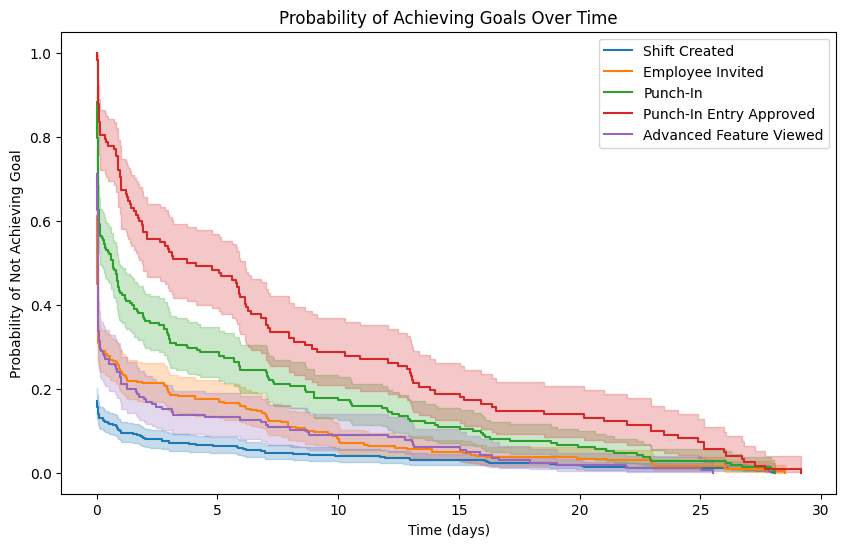

In [14]:


# Define goal activities for easy reference
goal_activities = {
    'Shift Created': 'Shift.Created',
    'Employee Invited': 'Hr.Employee.Invited',
    'Punch-In': 'PunchClock.PunchedIn',
    'Punch-In Entry Approved': 'PunchClock.Approvals.EntryApproved',
    'Advanced Feature Viewed': 'Page.Viewed'
}

# Function to calculate time to goal for each organization
def calculate_time_to_goal(data, activity, min_count=1, advanced_feature=False):
    if advanced_feature:
        activity_data = data[(data['activity_name'] == activity) & 
                             (data['activity_detail'].isin(['revenue', 'integrations-overview', 'absence-accounts', 'availability']))]
        goal_achieved = activity_data.groupby('organization_id')['activity_detail'].nunique() >= min_count
    else:
        activity_data = data[data['activity_name'] == activity]
        goal_achieved = activity_data.groupby('organization_id').size() >= min_count
    
    time_to_goal = activity_data.groupby('organization_id')['time_since_first_activity'].min() / (24 * 3600)
    return time_to_goal[goal_achieved]

# Calculate the time to achieve each goal
goal_times = {
    'Shift Created': calculate_time_to_goal(data, goal_activities['Shift Created'], min_count=2),
    'Employee Invited': calculate_time_to_goal(data, goal_activities['Employee Invited']),
    'Punch-In': calculate_time_to_goal(data, goal_activities['Punch-In']),
    'Punch-In Entry Approved': calculate_time_to_goal(data, goal_activities['Punch-In Entry Approved']),
    'Advanced Feature Viewed': calculate_time_to_goal(data, goal_activities['Advanced Feature Viewed'], min_count=2, advanced_feature=True)
}

# Kaplan-Meier Fitting
kmf = KaplanMeierFitter()

plt.figure(figsize=(10, 6))

for goal, times in goal_times.items():
    durations = times.values
    event_observed = np.ones(len(times))  # All events are observed for achieved goals
    
    # Fit the Kaplan-Meier model and plot
    kmf.fit(durations, event_observed, label=goal)
    kmf.plot_survival_function()

plt.title('Probability of Achieving Goals Over Time')
plt.xlabel('Time (days)')
plt.ylabel('Probability of Not Achieving Goal')
plt.legend()
plt.show()

Correlation matrix

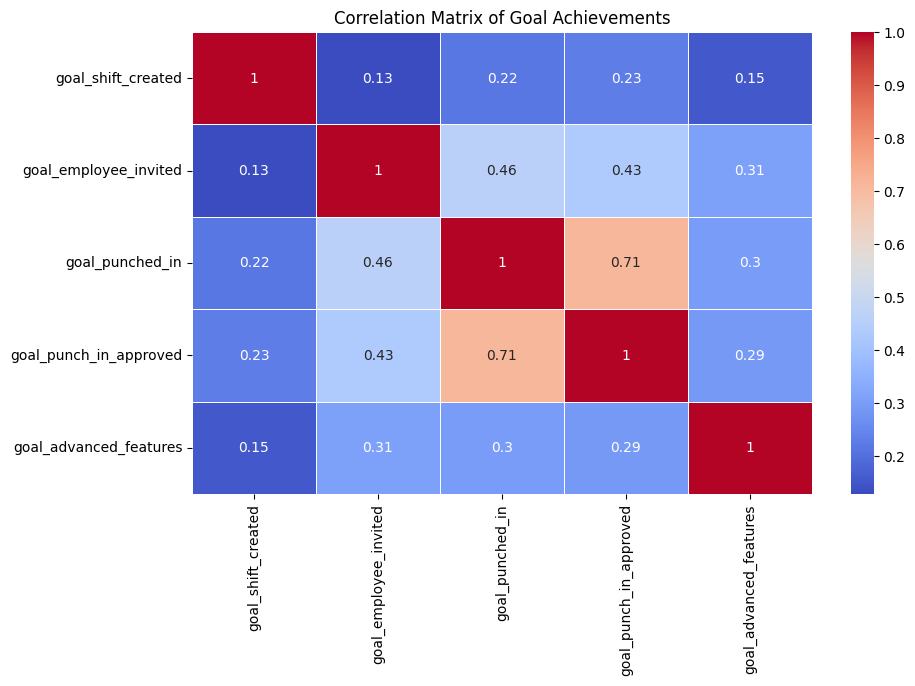

In [37]:
# Load the goal achievement data from the trial_goals table
goal_df = pd.read_sql('SELECT * FROM trial_goals', engine)

# Convert boolean values to integers for correlation analysis
goal_df.replace({True: 1, False: 0}, inplace=True)

# Calculate the correlation matrix
corr_matrix = goal_df.drop(columns=['organization_id']).corr()

# Plot the correlation matrix
plt.figure(figsize=(10, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Goal Achievements')
plt.show()
